In [1033]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.path as mpath
import pandasql as sql
import sys
from matplotlib.collections import LineCollection
from math import sin, cos, atan2, sqrt, degrees, radians, pi
from geopy.distance import great_circle as distance
from geopy.point import Point
from haversine import haversine,Unit
from scipy.cluster.hierarchy import dendrogram, linkage

In [1066]:
#filepath = r"C:\Users\NImi Jithin\Desktop\Studies\sem-3\research track\SegmentTable.csv"
#df = pd.read_csv(filepath)
#df = df.iloc[5500:6000]
#df = df.iloc[:500]

#filepath = r"C:\Users\NImi Jithin\Desktop\Studies\sem-3\research track\Measurements\m1.csv"
#measuresdf = pd.read_csv(filepath)
#measuresdf =  measuresdf.iloc[2000:5000]
#measuresdf =  measuresdf.iloc[0:,]

#-----these are the new SegmentTable and Measurement Table in which
#-----SegmentTable has : calucated  segment_midpoints, calculated segment_length
#-----Measurement Table has :  Predicted_SegmentNumber
#-----These tables are used once all the calculations are done 

df = pd.read_excel("C:/Users/NImi Jithin/Desktop/data/SegmentTable.xlsx")
measuresdf = pd.read_excel("C:/Users/NImi Jithin/Desktop/data/ms1.xlsx")

In [1067]:
len(measuresdf)

5771

In [1068]:
len(df)

8862

In [1069]:
#----- Finds the Minimum and Maximum Lat Long of Measurement Points
minX = measuresdf['long'].min()
maxX = measuresdf['long'].max()

minY = measuresdf['lat'].min()
maxY = measuresdf['lat'].max()
minX,maxX,minY,maxY

(10.334131, 10.434168, 51.79927, 51.902458)

In [1070]:
strtlon, strtlat = df.Start_Longitude.values, df.Start_Latitude.values
endlon, endlat = df.End_Longitude.values, df.End_Latitude.values

In [1071]:
pts = np.c_[strtlon, strtlat,endlon, endlat].reshape(len(strtlon), 2, 2)
xtrapts = pts[:len(pts)-0]
#xtrapts = pts[5000:5540,:] 

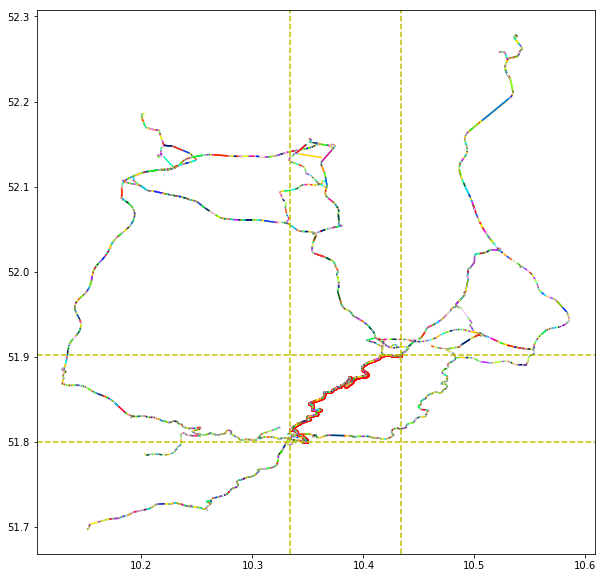

In [1072]:

#-----plot segments-------------------------------------------------------------

fig = plt.figure()
ax = fig.subplots()
ax.axhline(y=minY, color='y', ls='--')
ax.axhline(y=maxY, color='y', ls='--')
plt.axvline(x=minX, color='y', ls='--')
plt.axvline(x=maxX, color='y', ls='--')


#ax.set_xlim([minX, maxX])
#ax.set_ylim([minY, maxY])
#ax.margins(x=0.75, y=-0.1)

plt.rcParams["figure.figsize"] = (10,10)
coll = LineCollection(xtrapts, cmap=plt.cm.gist_ncar)
coll.set_array(np.random.random(xtrapts.shape[0]))

ax.add_collection(coll)
ax.autoscale_view()


#-----plot measurements ---------------------------------------------------------
xMeasurement, yMeasurement =  measuresdf.long.values, measuresdf.lat.values
ax.scatter(xMeasurement ,yMeasurement,s=1, color='r')
fig.savefig('C:/Users/NImi Jithin/Desktop/data/MessAndSegmentPlot.png',bbox_inches='tight')


In [869]:
#----- Finds MidPoint of a Segment with Coordinates A, B


"""def midpoint(a, b):
    a_lat, a_lon = radians(a.latitude), radians(a.longitude)
    b_lat, b_lon = radians(b.latitude), radians(b.longitude)
    delta_lon = b_lon - a_lon
    B_x = cos(b_lat) * cos(delta_lon)
    B_y = cos(b_lat) * sin(delta_lon)
    mid_lat = atan2(
        sin(a_lat) + sin(b_lat),
        sqrt(((cos(a_lat) + B_x)**2 + B_y**2))
    )
    mid_lon = a_lon + atan2(B_y, cos(a_lat) + B_x)
    # Normalise
    mid_lon = (mid_lon + 3*pi) % (2*pi) - pi
    return (degrees(mid_lat), degrees(mid_lon))
"""

'def midpoint(a, b):\n    a_lat, a_lon = radians(a.latitude), radians(a.longitude)\n    b_lat, b_lon = radians(b.latitude), radians(b.longitude)\n    delta_lon = b_lon - a_lon\n    B_x = cos(b_lat) * cos(delta_lon)\n    B_y = cos(b_lat) * sin(delta_lon)\n    mid_lat = atan2(\n        sin(a_lat) + sin(b_lat),\n        sqrt(((cos(a_lat) + B_x)**2 + B_y**2))\n    )\n    mid_lon = a_lon + atan2(B_y, cos(a_lat) + B_x)\n    # Normalise\n    mid_lon = (mid_lon + 3*pi) % (2*pi) - pi\n    return (degrees(mid_lat), degrees(mid_lon))\n'

In [871]:
#df['Segment_Length'] = ''

In [872]:
#-----Calculates mid point of each segment 
#-----Its done only once. Once all the midpoints of the segments are calculated,  its written to a new xl sheet,
#-----which is then used for further Calculations

for indexSeg, rowSeg in df.iterrows():
    a = Point(rowSeg['Start_Latitude'], longitude=rowSeg['Start_Longitude'])
    b = Point(rowSeg['End_Latitude'], longitude=rowSeg['End_Longitude'])
    #----- MidPoint Calculation
    x = midpoint(a,b)           
    df.loc[indexSeg,'Mid_Latitude'] = x[0]
    df.loc[indexSeg,'Mid_Longitude'] = x[1]
    #----- Segment_Length Calculation in kilometer(km)
    df.loc[indexSeg,'Segment_Length'] = distance(a,b)  

"for indexSeg, rowSeg in df.iterrows():\n    a = Point(rowSeg['Start_Latitude'], longitude=rowSeg['Start_Longitude'])\n    b = Point(rowSeg['End_Latitude'], longitude=rowSeg['End_Longitude'])\n    x = midpoint(a,b)\n    df.loc[indexSeg,'Mid_Latitude'] = x[0]\n    df.loc[indexSeg,'Mid_Longitude'] = x[1]\n    df.loc[indexSeg,'Segment_Length'] = distance(a,b)"

In [873]:
df.head()

,Segment_ID,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude,Segment_Length,Mid_Latitude,Mid_Longitude
0,1,10.128375,51.868551,10.128433,51.868380,0.019427,51.868466,10.128404
1,2,10.128384,51.868665,10.128375,51.868551,0.012691,51.868608,10.128379
2,3,10.128433,51.868380,10.128498,51.868291,0.010856,51.868336,10.128466
3,4,10.128443,51.885236,10.128478,51.884912,0.036107,51.885074,10.128461
4,5,10.128471,51.885496,10.128443,51.885236,0.028975,51.885366,10.128457


In [874]:
#----- writes the new Segment table with Segment_Length, Mid_Latitude, Mid_Longitude

# df.to_excel(r'C:\Users\NImi Jithin\Desktop\data\SegmentTable.xlsx')

In [878]:
len(df)

2189

In [563]:
#df['Segment_Length'] = df['Segment_Length'].astype(str).str[:-3].astype(float)

In [877]:
#----- Before calculating the distance of each Measurement Point to all the segments, this filters out the segment Table,
#----- so that we can reduce the number of computations
#----- Need to find the distance to the segments in the enclosed square box as in above  figure 

df = df[(df['Mid_Longitude'] >= minX) & (df['Mid_Longitude'] <= maxX) &
                      (df['Mid_Latitude'] >= minY) & (df['Mid_Latitude'] <= maxY)]

In [879]:
measuresdf['PredictedSeg'] = ''

In [880]:

def distCalc(measuredPoint, messDistMap):
    for indexSeg, rowSeg in df.iterrows():
        segmentMidPoint  = [rowSeg['Mid_Latitude'],rowSeg['Mid_Longitude']]
        segmentLength = rowSeg['Segment_Length']
        dist = distance(measuredPoint,segmentMidPoint).km
        #----- Normalised Distance
        normDist = dist/segmentLength  
        messDistMap.update({rowSeg['Segment_ID']:normDist})
    return messDistMap

In [881]:

for indexMess, rowMess in measuresdf.iterrows():
    messDistMap = dict()
    measuredLatLongPoint = [rowMess['lat'],rowMess['long']]
    #----- A map which stores, key: SegID  value : distance betwen measured point and the segment
    messDistMap = distCalc(measuredLatLongPoint, messDistMap) 
    if bool(messDistMap):
        #----- stores the SegmentID with minDist(Predicted_Segment)
        measuresdf.loc[indexMess,'PredictedSeg'] = min(messDistMap, key=messDistMap.get) 
       

In [1084]:
measuresdf.head()

,Unnamed: 0,time,lat,long,dir,velocity,T_outside,brightnessFW,brightnessIR,PredictedSeg
0,0,"Wednesday, November 1, 2017 16:17:31:83508813",51.900768,10.43236,0.0,0.0,12.5,827.398613,2000.0,6471
1,1,"Wednesday, November 1, 2017 16:17:32:33509545",51.900768,10.43236,0.0,0.0,12.5,827.398613,2000.0,6471
2,2,"Wednesday, November 1, 2017 16:17:32:83509277",51.900768,10.43236,0.0,0.0,12.5,828.000000,2000.0,6471
3,3,"Wednesday, November 1, 2017 16:17:33:33509008",51.900768,10.43236,0.0,0.0,12.5,827.395594,2000.0,6471
4,4,"Wednesday, November 1, 2017 16:17:33:83508715",51.900768,10.43236,0.0,0.0,12.5,824.368410,2000.0,6471


In [883]:
measuresdf.to_excel(r'C:\Users\NImi Jithin\Desktop\data\ms1.xlsx')

In [1096]:
#q1 = """SELECT distinct(PredictedSeg) FROM measuresdf  order by PredictedSeg """
q1 = """SELECT time, dir FROM measuresdf WHERE PredictedSeg=6471 """
test = sql.sqldf(q1, locals())
test

,time,dir
0,"Wednesday, November 1, 2017 16:17:31:83508813",0.0
1,"Wednesday, November 1, 2017 16:17:32:33509545",0.0
2,"Wednesday, November 1, 2017 16:17:32:83509277",0.0
3,"Wednesday, November 1, 2017 16:17:33:33509008",0.0
4,"Wednesday, November 1, 2017 16:17:33:83508715",0.0
5,"Wednesday, November 1, 2017 16:17:34:33509472",0.0
6,"Wednesday, November 1, 2017 16:17:34:83509179",0.0
7,"Wednesday, November 1, 2017 16:17:35:33508911",0.0
8,"Wednesday, November 1, 2017 16:17:35:83508642",0.0
9,"Wednesday, November 1, 2017 16:17:36:33509375",0.0


In [1097]:
test.to_excel(r'C:\Users\NImi Jithin\Desktop\data\test.xlsx')

In [1075]:
measuresdf = measuresdf[measuresdf['PredictedSeg'].isin(test['PredictedSeg'])]

In [1076]:
df = df[df['Segment_ID'].isin(test['PredictedSeg'])]

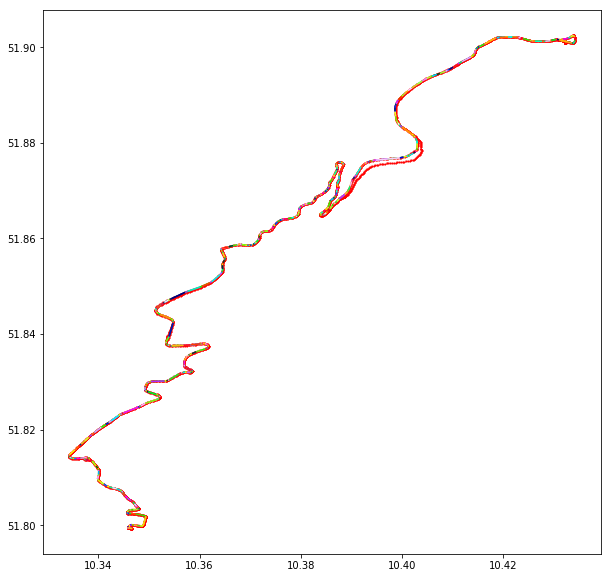

In [1079]:
strtlon, strtlat = df.Start_Longitude.values, df.Start_Latitude.values
endlon, endlat = df.End_Longitude.values, df.End_Latitude.values

pts = np.c_[strtlon, strtlat,endlon, endlat].reshape(len(strtlon), 2, 2)
xtrapts = pts[:len(pts)-0]

#plot segments-------------------------------------------------------------
fig = plt.figure()
ax = fig.subplots()
#ax.set_xlim([10.39, 10.46])
#ax.set_ylim([51.86, 51.90])
#plt.rcParams["figure.figsize"] = (10,10)
coll = LineCollection(xtrapts, cmap=plt.cm.gist_ncar)
coll.set_array(np.random.random(xtrapts.shape[0]))

ax.add_collection(coll)
ax.autoscale_view()

#plot measurements ---------------------------------------------------------
xMeasurement, yMeasurement =  measuresdf.long.values, measuresdf.lat.values
ax.scatter(xMeasurement,yMeasurement,s=1, marker=">",color='r')
fig.savefig('C:/Users/NImi Jithin/Desktop/data/predictedSeg1.png',bbox_inches='tight')

In [1078]:
len(df)

881

In [1091]:
q1 = """SELECT DISTINCT(PredictedSeg) FROM measuresdf  order by PredictedSeg """
test = sql.sqldf(q1, locals())
test.head()

,PredictedSeg
0,3135
1,3136
2,3142
3,3153
4,3158
